In [164]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.45 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Setup complete ✅ (12 CPUs, 7.7 GB RAM, 111.5/1006.9 GB disk)


In [165]:
!nvidia-smi

Sun Jul  7 23:08:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.03              Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  |   00000000:01:00.0  On |                  N/A |
| N/A   66C    P0             31W /   80W |    4566MiB /   6144MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Importar Módulos

In [166]:
import cv2
from PIL import Image
from ultralytics import YOLO, solutions
import IPython.display as dp

### Path imagen de prueba

In [167]:
img_test='/home/SafeCross/results/to_prbe/66.jpg'

### Path de los 3 pesos del entrenamiento con mejor resultado

In [168]:
weigths_path='weigths'
crosswalk_weight=f'{weigths_path}/crosswalks.pt'
lights_weight=f'{weigths_path}/lights.pt'
persons_cars_weigth=f'{weigths_path}/persons_cars.pt'

#### Funciones Auxiliares

In [169]:
import PIL as pil
def plot_image(results):
    # Visualize the results
    for i, r in enumerate(results):
        # Plot results image
        im_bgr = r.plot()  # BGR-order numpy array
        im_rgb = pil.Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

        # Show results to screen (in supported environments)
        r.show()

        # Save results to disk
        r.save(filename=f"crosswalk_model{i}.jpg")
        # Save weights to disk
        print(f'probabilidad {r.probs}')

In [170]:
from ultralytics.engine.results import Results
def get_bounding_boxes(results:list[Results])->list[dict]:
    temp:list[dict]=[]

    for result in results:
         #    {'coordinates': [10, 20, 100, 120], 'name': 'Objeto 1', 'probability': 0.9},
        # Extraer los nombres de los boxes
        result=result[0]
        names:dict[int,str]=result.names
        #print(f'names \n {names}')
        boxes=result.boxes
        #print(f'boxes \n {boxes}')
        types=list(map(int,boxes.cls.tolist()))
        #print(f'cls::: \n {type(types)}-- {types}')
        coordinates=boxes.xyxy.tolist()
        #print(f'coordinates \n {type(coordinates)} -- {coordinates} ')
        probs=boxes.conf.tolist()
        #print(probs)
        d={}
        for i,item in enumerate(coordinates,0):

             temp.append({'coordinates':item,'name':names[types[i]],'probability':probs[i]})
    
    return temp

In [171]:
import matplotlib as plt

In [172]:
import IPython.display as ipd
def draw_and_save_bounding_boxes(image_path: str,output_img_name:str, bbox_data_list:list[dict],output_path: str='/home/SafeCross/output_img'):
    """
        ## Ejemplo de uso
        #bbox_data_list = [
        #    {'coordinates': [10, 20, 100, 120], 'name': 'Objeto 1', 'probability': 0.9},
        #    {'coordinates': [150, 160, 250, 260], 'name': 'Objeto 2', 'probability': 0.8}
        #]
        #
        #draw_and_save_bounding_boxes('path/to/image.jpg', '/output_img', bbox_data_list)
        #
    """
    
    # Leer la imagen desde el path especificado
    image = cv2.imread(image_path)
    i = image_path.rfind('/')
    image_name = image_path[i + 1:-4]
    
    # Convertir la imagen a escala de grises para simplificar el proceso de dibujo
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Colores en base a los tags 
    # Definición de colores para diferentes etiquetas en RGB
    colores_etiquetas = {
    "car": (0, 0, 255),  # Rojo
    "person": (0, 255, 0),  # Verde
    "crosswalk": (255, 165, 0),  # Naranja
    "light": (255, 128, 0),  # otro
    }

    
    # Iterar sobre cada bounding box en la lista de datos
    for bbox_data in bbox_data_list:
        # Extraer las coordenadas del bounding box, el nombre y la probabilidad
        x_min, y_min, x_max, y_max = map(int, bbox_data['coordinates'])
        name = bbox_data['name']
        probability = bbox_data['probability']
        
        color=colores_etiquetas[name] if name in colores_etiquetas else (255, 128, 0)
        
        # Dibujar el bounding box en la imagen
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2) #azul rgb
        
        # Calcula la posición central del rectángulo para el texto
        text_x = int((x_min + x_max) / 2)
        text_y = int(y_min)  # Ajusta esto según dónde quieras colocar verticalmente el texto

        # Define el texto que quieres añadir
        nombre = f"{name}: {probability:.2f}"

        # Configura el estilo, tamaño y color del texto
        font_scale = 0.5
        font_thickness = 2
        text_color = (255, 125, 125)  # Rojo en BGR

        # Añade el texto encima del rectángulo
        cv2.putText(image, nombre, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)
    
    # Guardar la imagen con los bounding boxes en un nuevo archivo
    output_filename = f'{output_path}/{output_img_name}_{image_name}.jpg'
    success = cv2.imwrite(output_filename, image)
    if not success:
        print(f"Error al guardar la imagen: {output_filename}")
    
    # Mostrar la imagen con los bounding boxes dibujados en el cuaderno Jupyter
    ipd.display(ipd.Image(filename=output_filename))
    print(f'La imagen con los bounding boxes fue guardada y mostrada como {output_filename}')

## Cargar los modelos a YoloV8 por separado

In [173]:
crosswalk_model=YOLO(crosswalk_weight)
lights_model=YOLO(lights_weight)
persons_cars_model=YOLO(persons_cars_weigth)

## Ver resultados para el cruce de peatones


image 1/1 /home/SafeCross/results/to_prbe/66.jpg: 512x288 2 crosswalks, 54.9ms
Speed: 2.9ms preprocess, 54.9ms inference, 4.3ms postprocess per image at shape (1, 3, 512, 288)


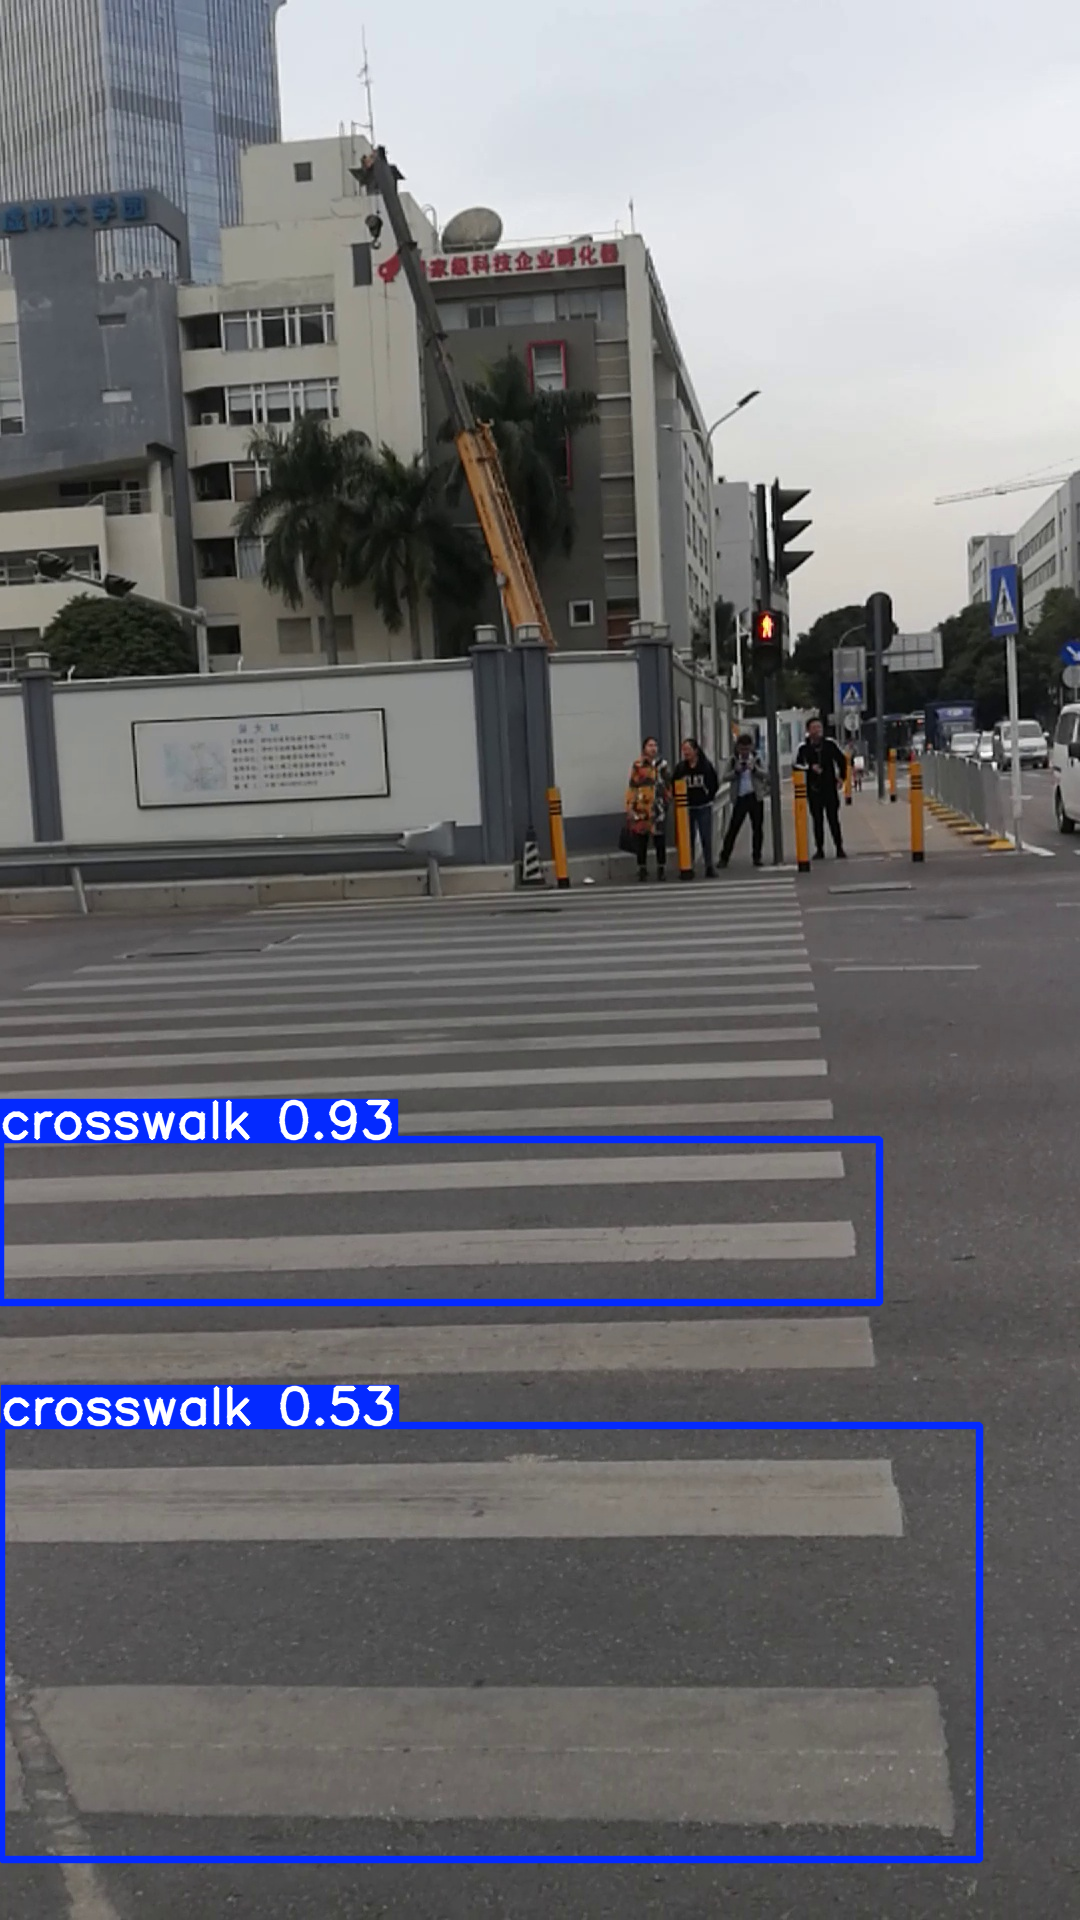

probabilidad None


In [174]:
crosswalks_results = crosswalk_model(img_test,conf=0.1)  # results list


plot_image(crosswalks_results)



image 1/1 /home/SafeCross/results/to_prbe/66.jpg: 480x288 4 persons, 17.9ms
Speed: 2.2ms preprocess, 17.9ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 288)


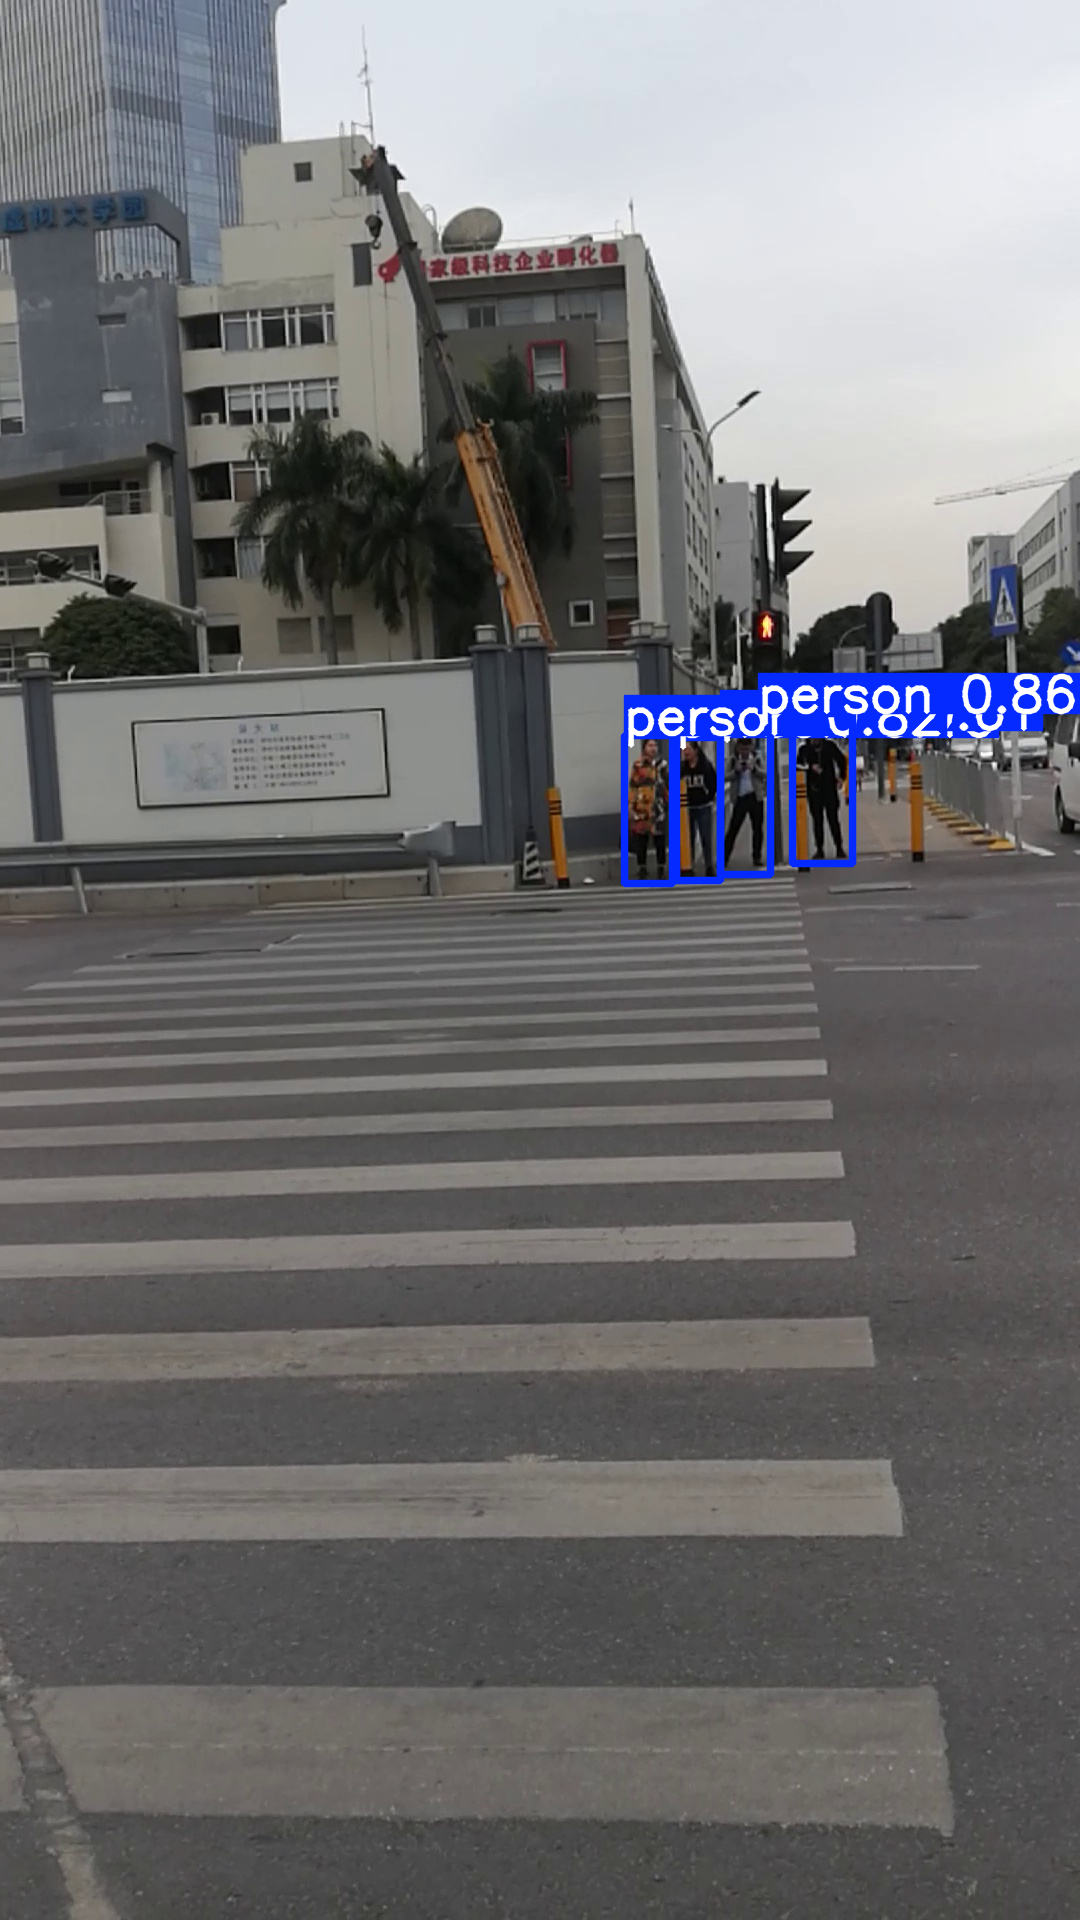

probabilidad None


In [175]:
from PIL import Image
persons_cars_results = persons_cars_model(img_test,)  # results list

plot_image(persons_cars_results)



image 1/1 /home/SafeCross/results/to_prbe/66.jpg: 640x384 1 rojo, 57.2ms
Speed: 3.8ms preprocess, 57.2ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 384)


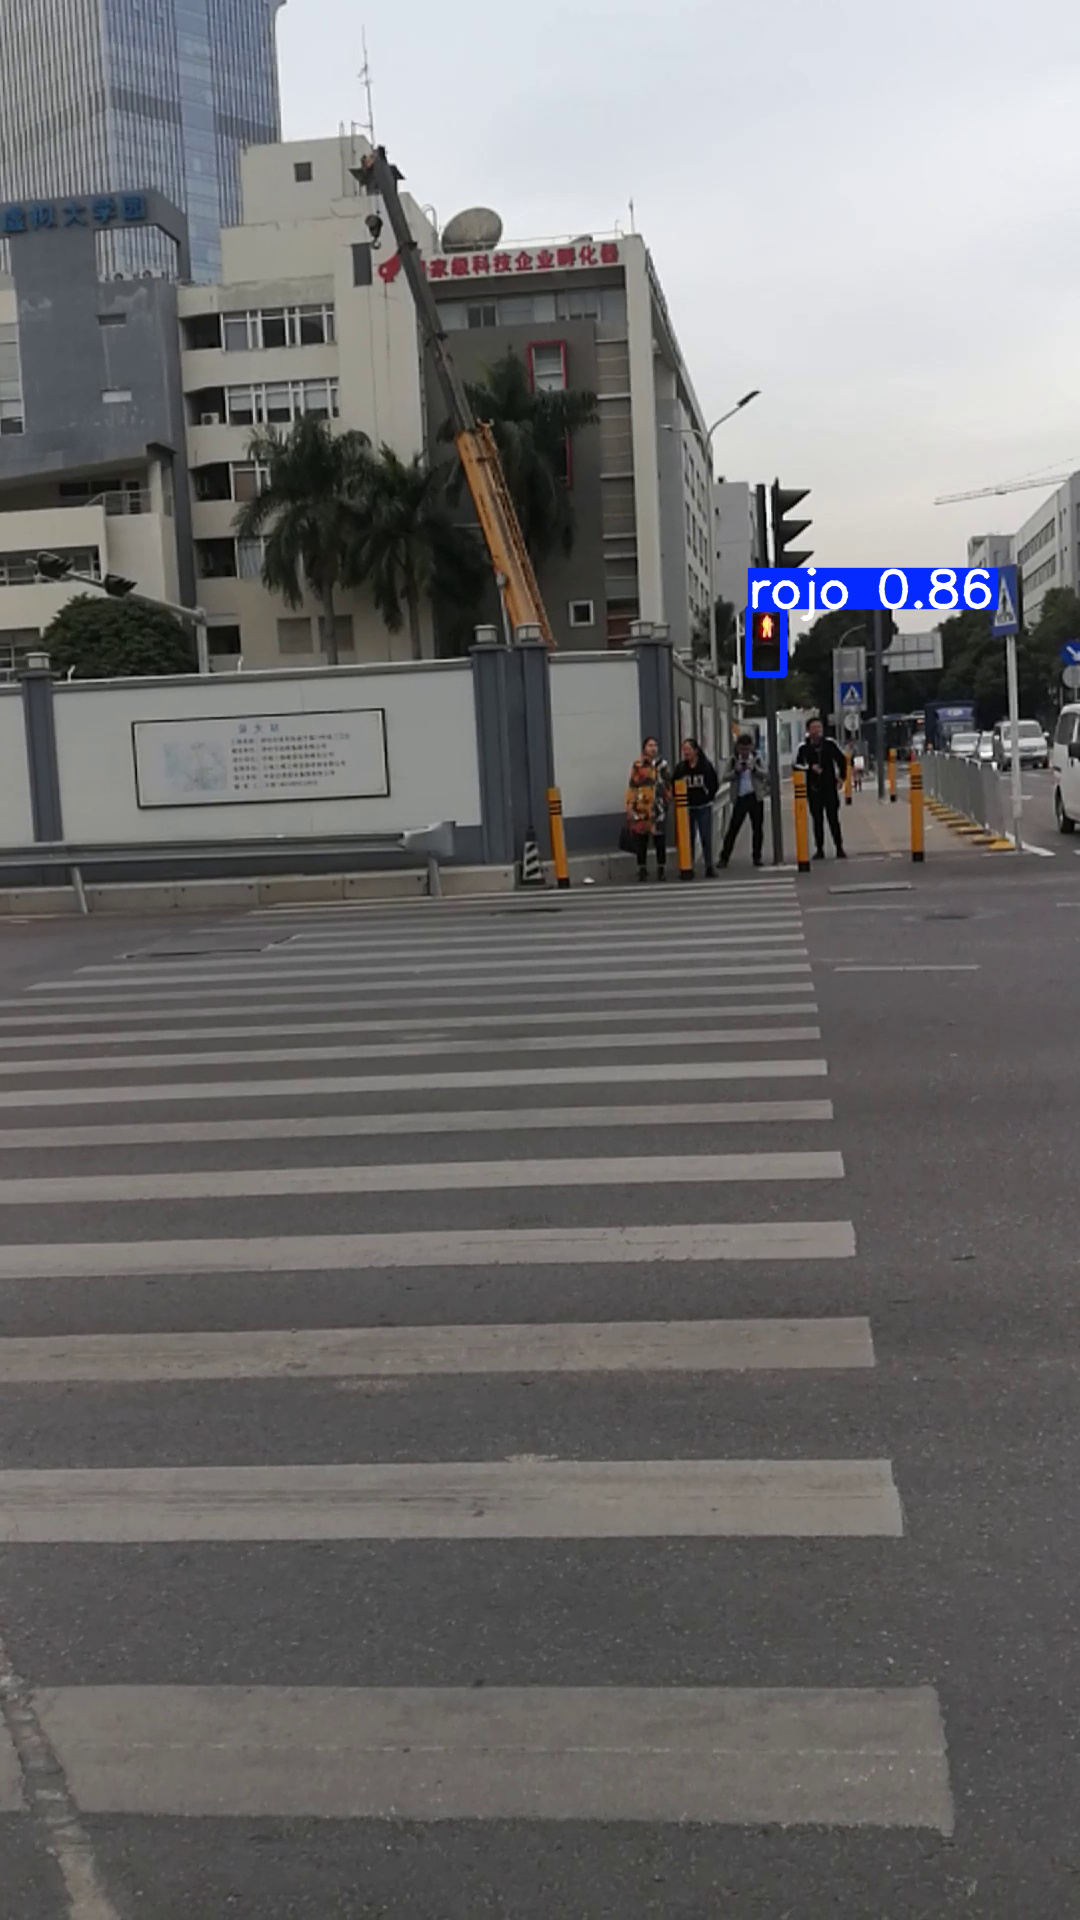

probabilidad None


In [176]:
lights_results=lights_model(img_test,)

plot_image(lights_results)

In [197]:
lights_results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'rojo', 1: 'amarillo', 2: 'verde'}
obb: None
orig_img: array([[[173, 174, 172],
        [145, 146, 144],
        [114, 115, 113],
        ...,
        [237, 230, 227],
        [237, 230, 227],
        [237, 230, 227]],

       [[174, 175, 173],
        [147, 148, 146],
        [116, 117, 115],
        ...,
        [237, 230, 227],
        [237, 230, 227],
        [237, 230, 227]],

       [[176, 177, 175],
        [150, 151, 149],
        [119, 120, 118],
        ...,
        [237, 230, 227],
        [237, 230, 227],
        [237, 230, 227]],

       ...,

       [[ 73,  75,  76],
        [ 73,  75,  76],
        [ 74,  76,  77],
        ...,
        [ 71,  73,  74],
        [ 71,  73,  74],
        [ 72,  74,  75]],

       [[ 72,  74,  75],
        [ 72,  74,  75],
        [ 73,  75,  76],
        ...,
        [ 72,  74,  75],
        [ 73,

In [198]:
box=lights_results[0].boxes

In [202]:
int(box.cls.tolist()[0])

0

In [177]:
boxes=get_bounding_boxes([crosswalks_results,persons_cars_results,lights_results])


In [178]:
boxes

[{'coordinates': [0.06299971789121628,
   1139.056884765625,
   879.0958862304688,
   1302.343994140625],
  'name': 'crosswalk',
  'probability': 0.9253484010696411},
 {'coordinates': [1.122207522392273,
   1425.5745849609375,
   979.6844482421875,
   1859.118408203125],
  'name': 'crosswalk',
  'probability': 0.533180832862854},
 {'coordinates': [792.870849609375,
   713.0068359375,
   852.099365234375,
   863.32177734375],
  'name': 'person',
  'probability': 0.861343264579773},
 {'coordinates': [624.9215698242188,
   735.2864379882812,
   672.0763549804688,
   883.4031372070312],
  'name': 'person',
  'probability': 0.8230535387992859},
 {'coordinates': [720.1558837890625,
   730.750732421875,
   770.666259765625,
   874.015625],
  'name': 'person',
  'probability': 0.6118708252906799},
 {'coordinates': [676.0224609375,
   737.0089111328125,
   720.2767333984375,
   880.9608154296875],
  'name': 'person',
  'probability': 0.45785582065582275},
 {'coordinates': [748.3079223632812,
  

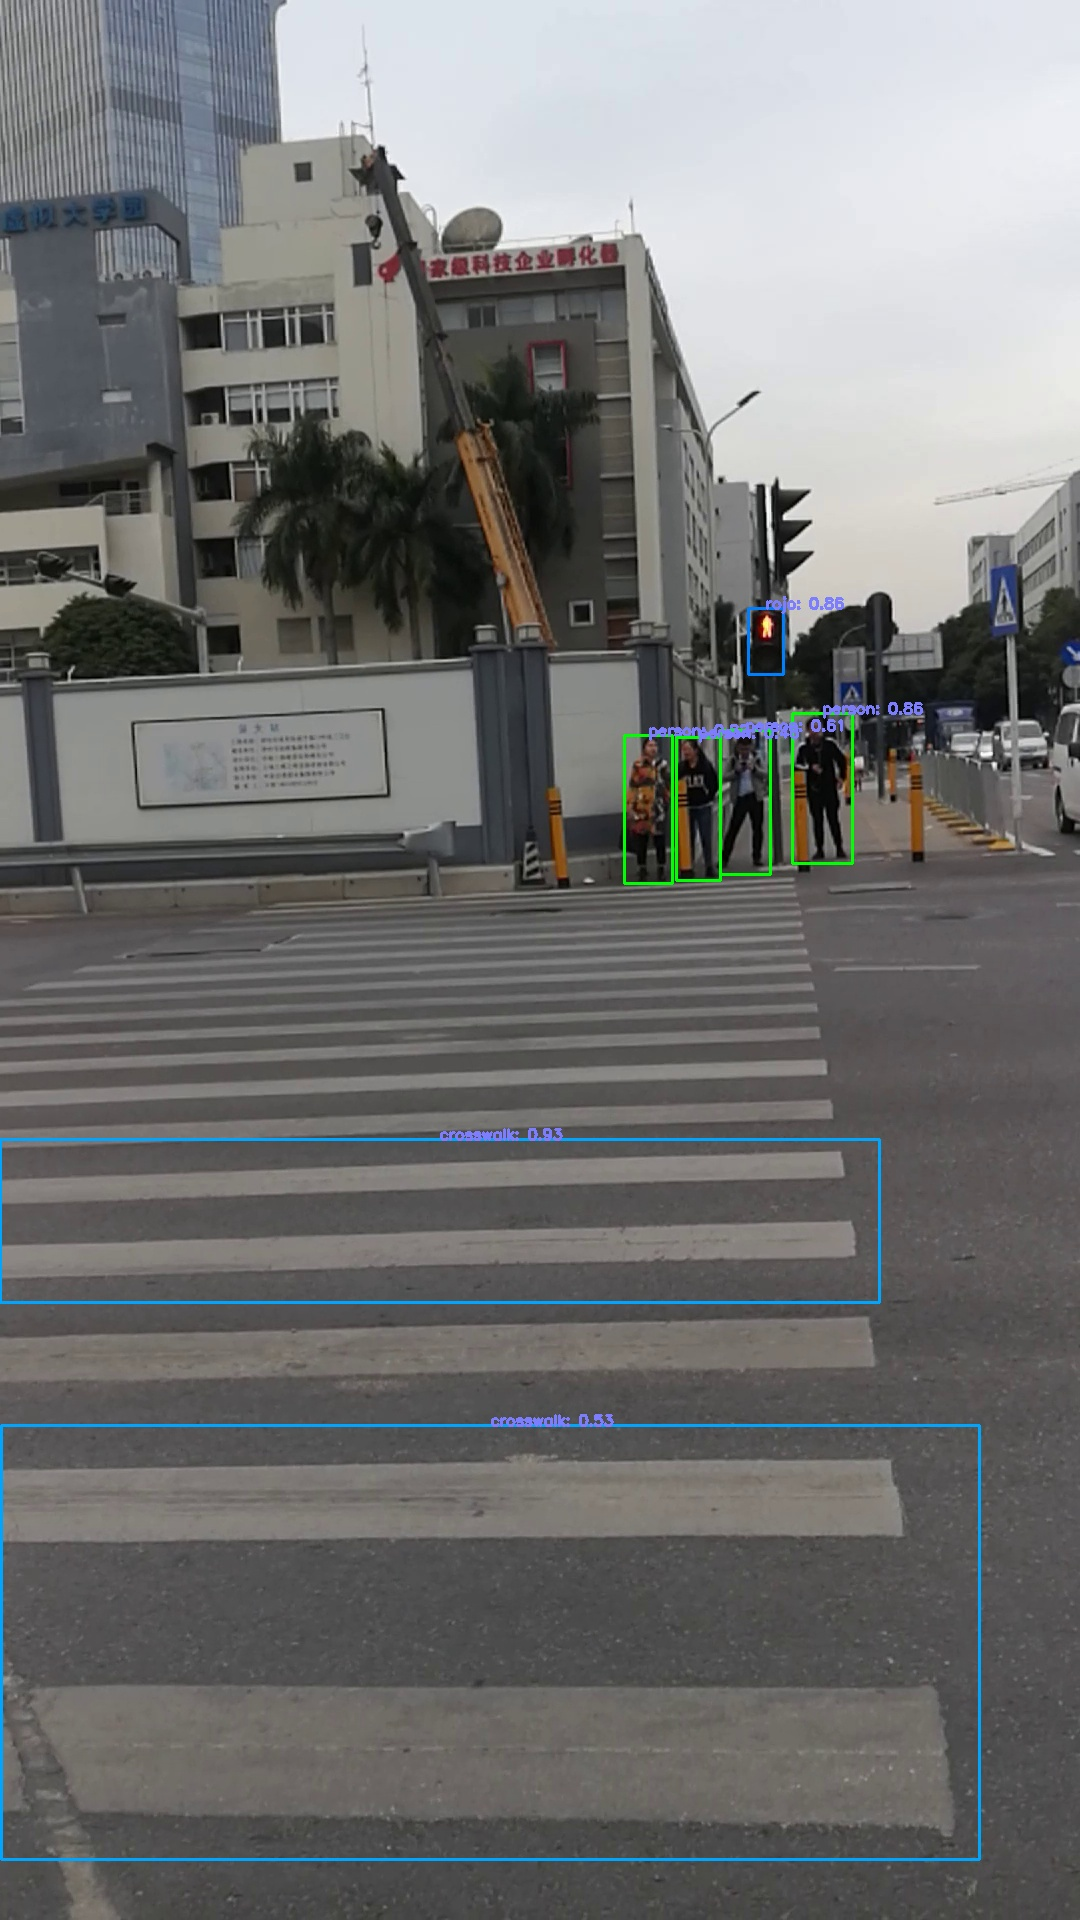

La imagen con los bounding boxes fue guardada y mostrada como /home/SafeCross/output_img/Final_66.jpg


In [179]:
draw_and_save_bounding_boxes(img_test,'Final', boxes)

In [180]:
#crosswalk_model.benchmark()

### Alinear los bounding boxes de los pasos de zebra

In [181]:
import glob
import os
import shutil
import numpy as np
import cv2 as cv

from matplotlib import pyplot as plt

# Algoritmo para mezclar bounding_boxes

In [182]:
import numpy as np

In [183]:
def merge_bounding_boxes(bounding_boxes:list[dict],image_width,image_height):
    """_summary_

    Args:
        bounding_boxes (list[dict]): _description_
        image_width (_type_): _description_
        image_height (_type_): _description_

    Returns:
         _type_: _description_
         
     """
    
    [x,y] = [image_height,image_width]
    [w,h] = [0,0]
    # Tomar  las probabilidades
    probs=[]
    name=bounding_boxes[0]['name']
    for item in bounding_boxes:
        assert item['name']==name,'Se deben mezclar cajas delimitadoras de igual tipo '
          
        probs.append(item['probability'])
        coordinates=item['coordinates'] 
        if len(bounding_boxes)==1:
            center_x_1 = int(coordinates[0]*image_width)
            center_y_1 = int(coordinates[1]*image_height)
            width_1 = int(coordinates[2]*image_width)
            height_1 = int(coordinates[3]*image_height)
            x = int(center_x_1 - (width_1/2))
            y = int(center_y_1 - (height_1/2))
            w = int(center_x_1 + (width_1/2))
            h = int(center_y_1 + (height_1/2))
            
        else:
          
            center_x_1 = int(coordinates[0]*image_width)
            center_y_1 = int(coordinates[1]*image_height)
            width_1 = int(coordinates[2]*image_width)
            height_1 = int(coordinates[3]*image_height)
            vert_x = int(center_x_1 - (width_1/2))
            vert_y = int(center_y_1 - (height_1/2))
            vert_w = int(center_x_1 + (width_1/2))
            vert_h = int(center_y_1 + (height_1/2))

            if(vert_x < x):
              x = vert_x
            if(vert_y < y):
              y = vert_y
            if(vert_w > w):
              w = vert_w
            if(vert_h > h):
              h = vert_h
              
               
    
    return [{'coordinates': [x,y,w,h],
  'name':name,
  'probability': max(probs)},
 ]
      
    

In [184]:
new_boxes=get_bounding_boxes([crosswalks_results])
new_boxes

[{'coordinates': [0.06299971789121628,
   1139.056884765625,
   879.0958862304688,
   1302.343994140625],
  'name': 'crosswalk',
  'probability': 0.9253484010696411},
 {'coordinates': [1.122207522392273,
   1425.5745849609375,
   979.6844482421875,
   1859.118408203125],
  'name': 'crosswalk',
  'probability': 0.533180832862854}]

In [185]:
image = cv.imread(img_test)
[image_height, image_width, levels] = image.shape
print(image_height, image_width, levels)

1920 1080 3


In [186]:
a=merge_bounding_boxes(new_boxes,image_width,image_height)
a

[{'coordinates': [-527818, 1080, 530240, 4521856],
  'name': 'crosswalk',
  'probability': 0.9253484010696411}]

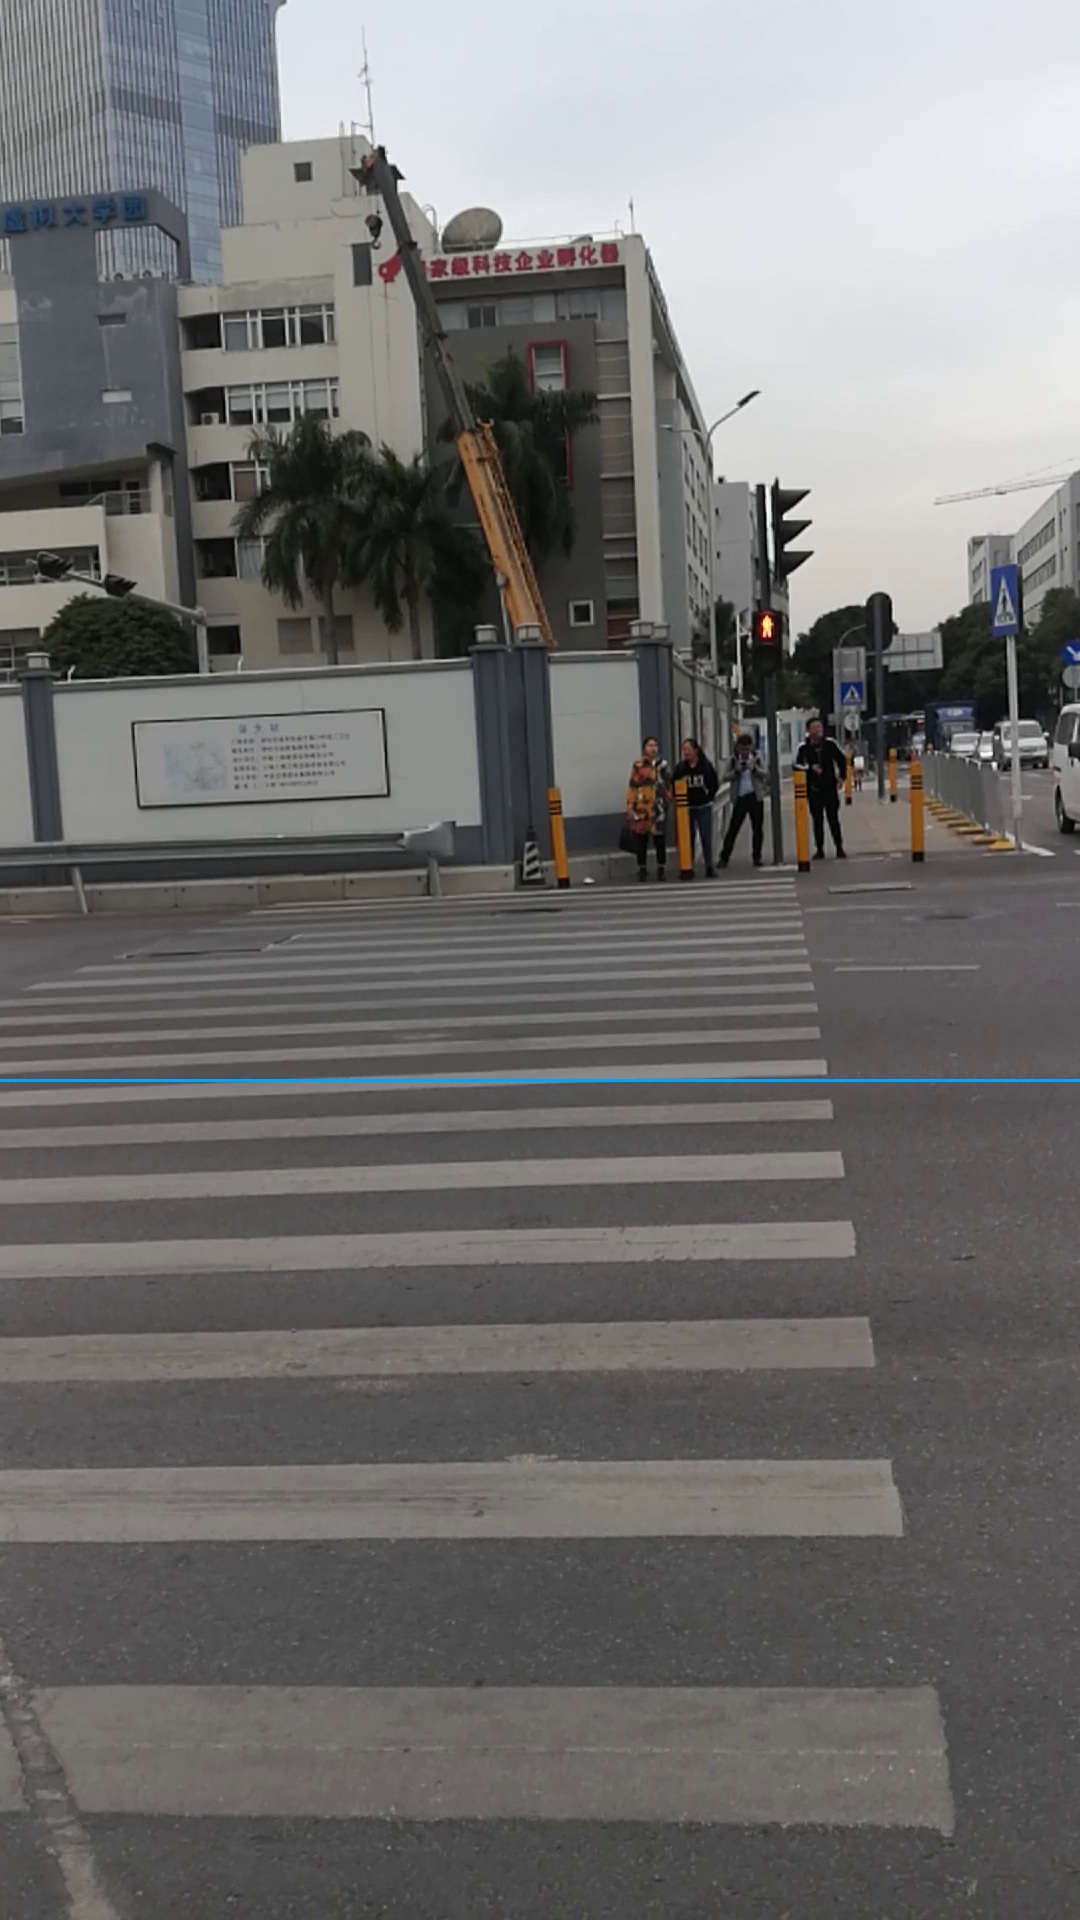

La imagen con los bounding boxes fue guardada y mostrada como /home/SafeCross/output_img/merge_boxes_66.jpg


In [187]:
draw_and_save_bounding_boxes(img_test,'merge_boxes', a)

In [188]:
bb=None
confidences=None
for item in new_boxes:
    aa=np.array(item['coordinates'])
    bb=((np.vstack((bb, aa)) if (bb is not None) else aa))
    b=float(item['probability'])
    confidences=(np.vstack((confidences, b)) if (confidences is not None) else b)

In [189]:
def merge_bounding_boxes(bounding_boxes,image_width,image_height):
  [x,y] = [image_height,image_width]
  [w,h] = [0,0]
  for i in range(0,bounding_boxes.shape[0]):
    if(bounding_boxes.ndim == 1):
      center_x_1 = int(bounding_boxes[0]*image_width)
      center_y_1 = int(bounding_boxes[1]*image_height)
      width_1 = int(bounding_boxes[2]*image_width)
      height_1 = int(bounding_boxes[3]*image_height)
      x = int(center_x_1 - (width_1/2))
      y = int(center_y_1 - (height_1/2))
      w = int(center_x_1 + (width_1/2))
      h = int(center_y_1 + (height_1/2))
    else:
      center_x_1 = int(bounding_boxes[i,0]*image_width)
      center_y_1 = int(bounding_boxes[i,1]*image_height)
      width_1 = int(bounding_boxes[i,2]*image_width)
      height_1 = int(bounding_boxes[i,3]*image_height)
      vert_x = int(center_x_1 - (width_1/2))
      vert_y = int(center_y_1 - (height_1/2))
      vert_w = int(center_x_1 + (width_1/2))
      vert_h = int(center_y_1 + (height_1/2))
      if(vert_x < x):
        x = vert_x
      if(vert_y < y):
        y = vert_y
      if(vert_w > w):
        w = vert_w
      if(vert_h > h):
        h = vert_h
    return np.array([x,y,w,h])

In [190]:
nn=merge_bounding_boxes(bb,image_width,image_height)
nn

array([-474643,    1080,  474779, 3437239])

In [191]:
ss=[{'coordinates': nn,
  'name': 'crosswalk',
  'probability': 0.9539660811424255}]

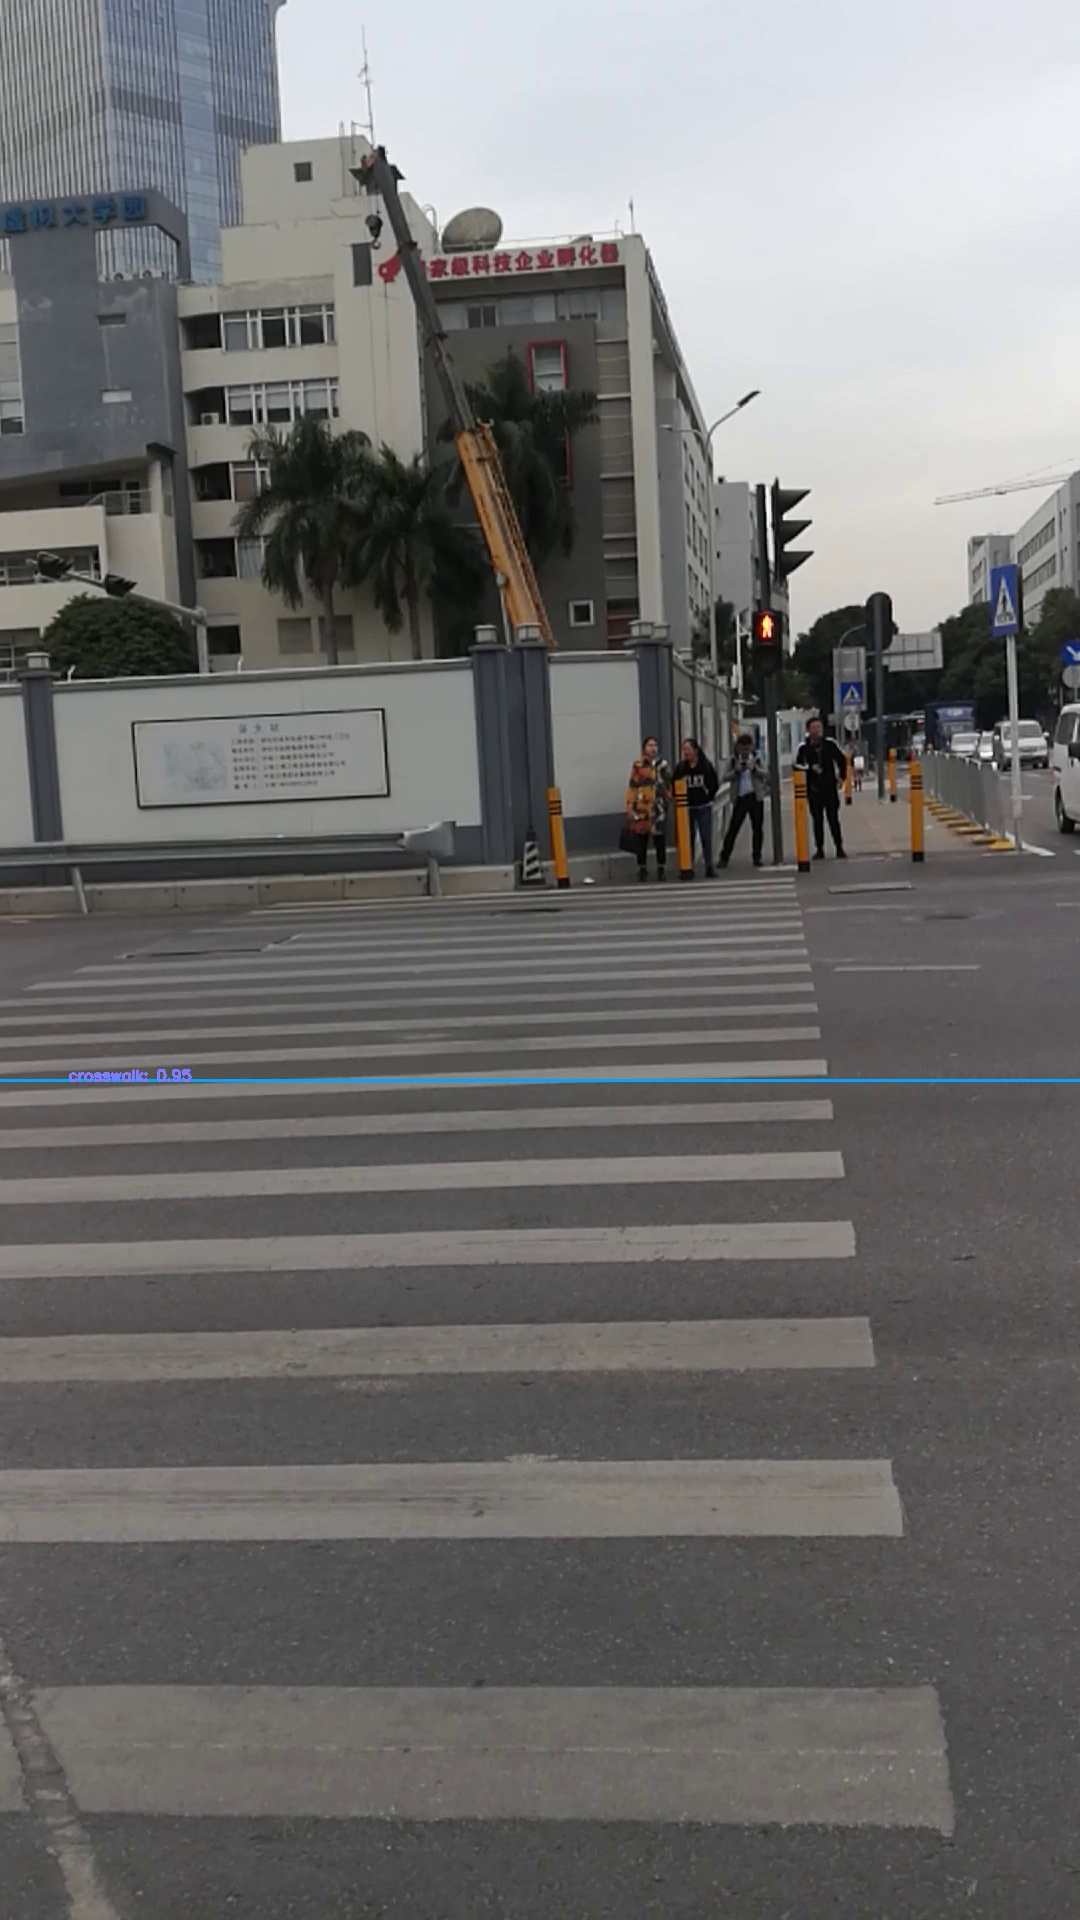

La imagen con los bounding boxes fue guardada y mostrada como /home/SafeCross/output_img/merge_boxes_66.jpg


In [192]:
draw_and_save_bounding_boxes(img_test,'merge_boxes', ss)

In [193]:
bounding_boxes=nn

In [194]:
bounding_boxes

array([-474643,    1080,  474779, 3437239])

In [195]:
image = cv.imread(img_test)
[image_height, image_width, levels] = image.shape
conf_max = np.amax(confidences)
[x,y,w,h] = merge_bounding_boxes(bounding_boxes, image_width, image_height)
#Create Rect
cv.rectangle(image, (x,y), (w,h), (0,0,255), 4)
cv.putText(image, 'crosswalk ' + "%.2f" % conf_max, (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
#Saving Image
print('Saving ' )
cv.imwrite(f'/home/SafeCross/ii.jpg', image)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 1 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 1 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


/////////
0 1056 590 1261
---------
/////////
0 890 589 970
---------
/////////
0 918 589 1016
---------


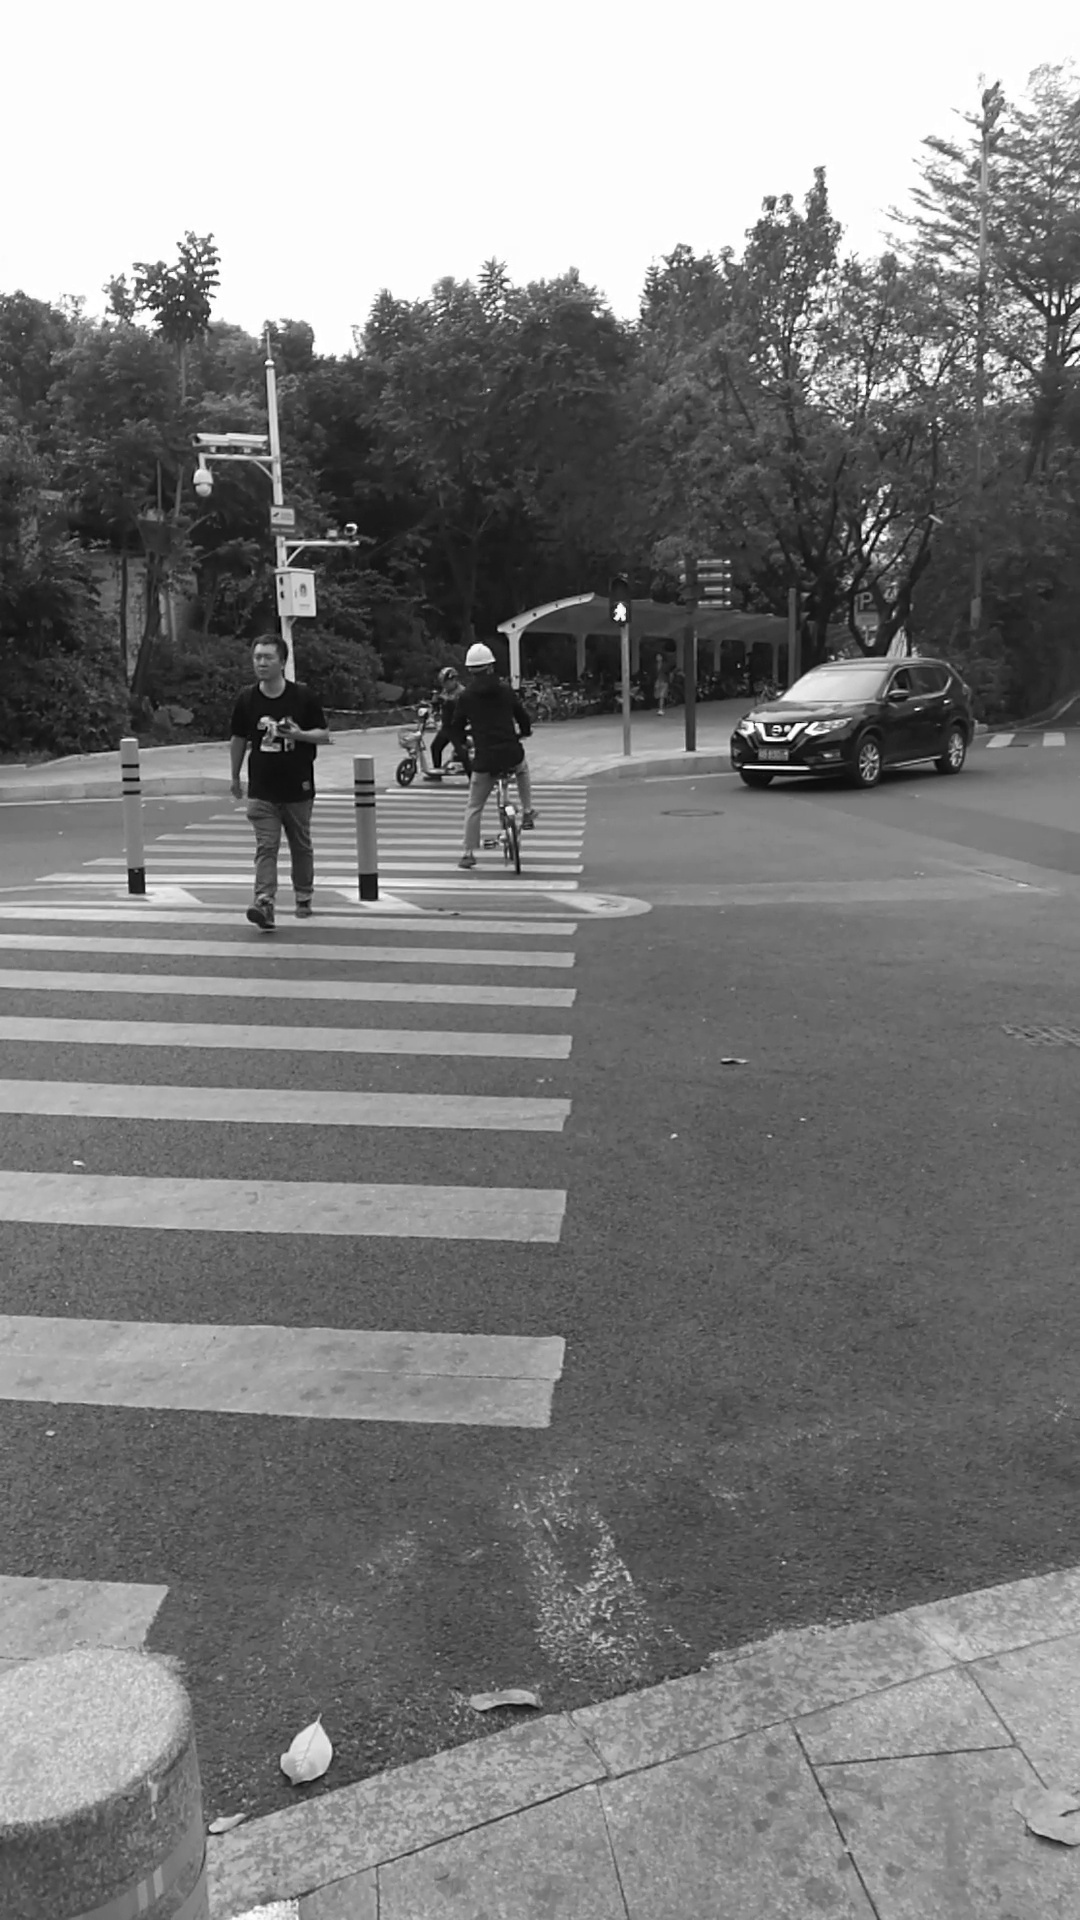

La imagen con los bounding boxes fue guardada y mostrada como merx.jpg


In [ ]:
import cv2
import numpy as np

def calcular_angulo(centro1, centro2):
  """Calcula el ángulo entre dos puntos (centros de las cajas)."""
  x1, y1 = centro1
  x2, y2 = centro2
  return np.arctan2(y2 - y1, x2 - x1)

def fusionar_cajas(cajas, umbral_angulo=20):
  """Fusiona cajas delimitadoras consecutivas o dentro de un ángulo."""
  cajas_fusionadas = []
  i = 0
  while i < len(cajas):
    caja_actual = cajas[i]
    # Si hay más cajas, compruébalas
    if i + 1 < len(cajas):
      caja_siguiente = cajas[i + 1]
      # Calcula los centros de las cajas
      centro_actual = (caja_actual[0] + caja_actual[2] / 2, caja_actual[1] + caja_actual[3] / 2)
      centro_siguiente = (caja_siguiente[0] + caja_siguiente[2] / 2, caja_siguiente[1] + caja_siguiente[3] / 2)
      
      # Comprueba si las cajas son consecutivas
      if caja_siguiente[0] - (caja_actual[0] + caja_actual[2]) < 10:  # Ajustado para x, w
        # Calcula el ángulo entre los centros de las cajas
        angulo = calcular_angulo(centro_actual, centro_siguiente)
        # Si el ángulo es menor que el umbral, fusiona las cajas
        if abs(angulo * 180 / np.pi) < umbral_angulo:
          # Fusiona las cajas (encuentra la caja más grande)
          caja_fusionada = [
              min(caja_actual[0], caja_siguiente[0]),
              min(caja_actual[1], caja_siguiente[1]),
              max(caja_actual[2], caja_siguiente[2]),
              max(caja_actual[3], caja_siguiente[3])
          ]
          cajas_fusionadas.append(caja_fusionada)
          i += 2  # Salta la siguiente caja
        else:
          cajas_fusionadas.append(caja_actual)
          i += 1
      else:
        cajas_fusionadas.append(caja_actual)
        i += 1
    else:
      cajas_fusionadas.append(caja_actual)
      i += 1
  return cajas_fusionadas

# Ejemplo de uso:
imagen = cv2.imread(img_test)  # Carga tu imagen
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Tus cajas delimitadoras (x, y, w, h)
cajas_delimitadoras = bb

cajas_fusionadas = fusionar_cajas(cajas_delimitadoras)
# Dibujar las cajas fusionadas en la imagen
for caja in cajas_fusionadas:
    x, y, w, h = map(int,caja)
    print('/////////')
    print(x,y,w,h)
    print('---------')
    # Corrección: Pasar coordenadas como tuplas
    cv2.rectangle(imagen, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde para fusionadas

# Dibujar las cajas originales en la imagen
for caja in cajas_delimitadoras:
    x, y, w, h = map(int,caja)
    # Corrección: Pasar coordenadas como tuplas
    cv2.rectangle(imagen, (x, y), (x + w, y + h), (0, 0, 255), 1)  # Rojo para originales

#cv2.imshow("Imagen con cajas", imagen)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
  
 # Guardar la imagen con los bounding boxes en un nuevo archivo
output_filename = f'merx.jpg'
success = cv2.imwrite(output_filename, image)
if not success:
    print(f"Error al guardar la imagen: {output_filename}")

# Mostrar la imagen con los bounding boxes dibujados en el cuaderno Jupyter
ipd.display(ipd.Image(filename=output_filename))
print(f'La imagen con los bounding boxes fue guardada y mostrada como {output_filename}')

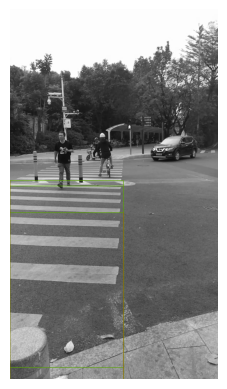

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def calcular_angulo(centro1, centro2):
  """Calcula el ángulo entre dos puntos (centros de las cajas)."""
  x1, y1 = centro1
  x2, y2 = centro2
  return np.arctan2(y2 - y1, x2 - x1)

def fusionar_cajas(cajas, umbral_angulo=20):
  """Fusiona cajas delimitadoras consecutivas o dentro de un ángulo."""
  cajas_fusionadas = []
  i = 0
  while i < len(cajas):
    caja_actual = cajas[i]
    # Si hay más cajas, compruébalas
    if i + 1 < len(cajas):
      caja_siguiente = cajas[i + 1]
      # Calcula los centros de las cajas
      centro_actual = (caja_actual[0] + caja_actual[2] / 2, caja_actual[1] + caja_actual[3] / 2)
      centro_siguiente = (caja_siguiente[0] + caja_siguiente[2] / 2, caja_siguiente[1] + caja_siguiente[3] / 2)
      
      # Comprueba si las cajas son consecutivas
      if caja_siguiente[0] - (caja_actual[0] + caja_actual[2]) < 10:  # Ajustado para x, w
        # Calcula el ángulo entre los centros de las cajas
        angulo = calcular_angulo(centro_actual, centro_siguiente)
        # Si el ángulo es menor que el umbral, fusiona las cajas
        if abs(angulo * 180 / np.pi) < umbral_angulo:
          # Fusiona las cajas (encuentra la caja más grande)
          caja_fusionada = [
              min(caja_actual[0], caja_siguiente[0]),
              min(caja_actual[1], caja_siguiente[1]),
              max(caja_actual[2], caja_siguiente[2]),
              max(caja_actual[3], caja_siguiente[3])
          ]
          cajas_fusionadas.append(caja_fusionada)
          i += 2  # Salta la siguiente caja
        else:
          cajas_fusionadas.append(caja_actual)
          i += 1
      else:
        cajas_fusionadas.append(caja_actual)
        i += 1
    else:
      cajas_fusionadas.append(caja_actual)
      i += 1
  return cajas_fusionadas

# Ejemplo de uso:
imagen = cv2.imread(img_test)  # Carga tu imagen

# Tus cajas delimitadoras (x, y, w, h)
cajas_delimitadoras =bb

cajas_fusionadas = fusionar_cajas(cajas_delimitadoras)

# Dibujar las cajas fusionadas en la imagen
for caja in cajas_fusionadas:
    x, y, w, h = map(int,caja)
    # Corrección: Pasar coordenadas como tuplas
    cv2.rectangle(imagen, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde para fusionadas

# Dibujar las cajas originales en la imagen
for caja in cajas_delimitadoras:
    x, y, w, h = map(int,caja)
    # Corrección: Pasar coordenadas como tuplas
    cv2.rectangle(imagen, (x, y), (x + w, y + h), (0, 0, 255), 1)  # Rojo para originales

#cv2.imshow("Imagen con cajas", imagen)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
# Guardar la imagen
cv2.imwrite("imagen_con_cajas.jpg", imagen)

# Mostrar la imagen en Jupyter
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB para pyplot
plt.axis('off')  # Ocultar ejes
plt.show()